In [ ]:
# Code to confirm your files are uploaded correctly
import os
print("Files available:")
for file in os.listdir():
    if file.endswith('.csv'):
        print(f"- {file}")

Files available:
- SanFrancisco_salary (csv).csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set style for visualizations
plt.style.use('fivethirtyeight')
sns.set_palette("muted")

In [ ]:
try:
    # Try to load the dataset (change the filename to what you have)
    data = pd.read_csv('/content/SanFrancisco_salary (csv).csv')  # Change this to your actual file name

    print("Dataset loaded successfully!")
    print(f"Number of rows: {data.shape[0]}")
    print(f"Number of columns: {data.shape[1]}")
    print("\nFirst 5 rows:")
    print(data.head())

    print("\nColumn names in the dataset:")
    for col in data.columns:
        print(f"- {col}")

except FileNotFoundError:
    print("File not found! Please check the filename and path.")
    # You might need to upload the file or correct the path
    # For this example, let's create a sample dataset to continue
    print("\nCreating a sample dataset to demonstrate the process...")

    # Create a sample dataset with common homelessness-related columns
    np.random.seed(42)
    years = range(2000, 2020)
    data = pd.DataFrame({
        'year': list(years),
        'homeless_count': np.random.randint(5000, 8000, len(years)),
        'median_rent': np.random.randint(1000, 3000, len(years)),
        'median_income': np.random.randint(60000, 120000, len(years)),
        'unemployment_rate': np.random.uniform(0.03, 0.08, len(years)),
        'poverty_rate': np.random.uniform(0.10, 0.20, len(years)),
        'housing_units': np.random.randint(300000, 400000, len(years)),
        'population': np.random.randint(750000, 900000, len(years))
    })

    print("Sample dataset created.")
    print(data.head())

Dataset loaded successfully!
Number of rows: 111881
Number of columns: 13

First 5 rows:
   Unnamed: 0     Id        EmployeeName                      JobTitle  \
0       36159  36160      Gary Altenberg  Lieutenant, Fire Suppression   
1       36160  36161        Gregory Suhr               Chief of Police   
2       36161  36162          Khoa Trinh   Electronic Maintenance Tech   
3       36162  36163  Joanne Hayes-White        Chief, Fire Department   
4       36163  36164   Frederick Binkley     EMT/Paramedic/Firefighter   

     BasePay  OvertimePay  OtherPay  Benefits   TotalPay  TotalPayBenefits  \
0  128808.87    220909.48  13126.31  44430.12  362844.66         407274.78   
1  302578.00         0.00  18974.11  69810.19  321552.11         391362.30   
2  111921.00    146415.32  78057.41  53102.29  336393.73         389496.02   
3  296943.01         0.00  17816.59  72047.88  314759.60         386807.48   
4  126863.19    192424.49  17917.18  44438.25  337204.86         381643.11  

In [ ]:
print("\n--- EXPLORATORY DATA ANALYSIS ---")

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Handle missing values if needed
if data.isnull().sum().sum() > 0:
    print("Filling missing values with column medians...")
    data = data.fillna(data.median())

# Check data types
print("\nData types:")
print(data.dtypes)

# Example Visualization 1: Housing costs over time (if columns exist)
if all(col in data.columns for col in ['year', 'median_rent']):
    plt.figure(figsize=(12, 6))
    plt.plot(data['year'], data['median_rent'], marker='o', linewidth=2)
    plt.title('Median Rent Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Median Monthly Rent ($)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping rent visualization - required columns not found")

# Example Visualization 2: Homelessness counts over time (if columns exist)
if all(col in data.columns for col in ['year', 'homeless_count']):
    plt.figure(figsize=(12, 6))
    plt.bar(data['year'], data['homeless_count'])
    plt.title('Homelessness Count Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Homeless Individuals', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping homelessness count visualization - required columns not found")

# Example Visualization 3: Correlation between factors (if enough columns exist)
correlation_columns = [col for col in [
    'median_rent', 'median_income', 'homeless_count',
    'unemployment_rate', 'poverty_rate'
] if col in data.columns]

if len(correlation_columns) > 1:
    # Create correlation matrix
    correlation_matrix = data[correlation_columns].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Between Factors', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping correlation heatmap - not enough comparable columns found")



--- EXPLORATORY DATA ANALYSIS ---

Missing values in each column:
Unnamed: 0          0
Id                  0
EmployeeName        0
JobTitle            0
BasePay             0
OvertimePay         0
OtherPay            0
Benefits            0
TotalPay            0
TotalPayBenefits    0
Year                0
Department          0
Department_ML       0
dtype: int64

Data types:
Unnamed: 0            int64
Id                    int64
EmployeeName         object
JobTitle             object
BasePay             float64
OvertimePay         float64
OtherPay            float64
Benefits            float64
TotalPay            float64
TotalPayBenefits    float64
Year                  int64
Department           object
Department_ML         int64
dtype: object
Skipping rent visualization - required columns not found
Skipping homelessness count visualization - required columns not found
Skipping correlation heatmap - not enough comparable columns found


In [ ]:
print("\n--- FEATURE ENGINEERING ---")

# Track newly created features
new_features = []

# Feature 1: Housing Cost Burden (if possible)
if all(col in data.columns for col in ['median_rent', 'median_income']):
    print("Creating 'housing_cost_burden' feature...")
    data['housing_cost_burden'] = data['median_rent'] / (data['median_income'] / 12)
    new_features.append('housing_cost_burden')

    # Visualize new feature
    plt.figure(figsize=(12, 6))
    plt.plot(data['year'], data['housing_cost_burden'], marker='o', linewidth=2)
    plt.title('Housing Cost Burden Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Rent as a Portion of Monthly Income', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot create 'housing_cost_burden' - required columns missing")

# Feature 2: Housing Supply Gap (if possible)
if all(col in data.columns for col in ['population', 'housing_units']):
    print("Creating 'housing_supply_gap' feature...")
    data['housing_supply_gap'] = data['population'] / data['housing_units']
    new_features.append('housing_supply_gap')
else:
    print("Cannot create 'housing_supply_gap' - required columns missing")

# Feature 3: Homelessness Rate (if possible)
if all(col in data.columns for col in ['homeless_count', 'population']):
    print("Creating 'homelessness_rate' feature...")
    data['homelessness_rate'] = data['homeless_count'] / data['population'] * 10000  # per 10,000 people
    new_features.append('homelessness_rate')
else:
    print("Cannot create 'homelessness_rate' - required columns missing")

# Show newly created features if any
if new_features:
    print("\nNewly created features:")
    print(data[new_features].describe())
else:
    print("No new features could be created from available data")



--- FEATURE ENGINEERING ---
Cannot create 'housing_cost_burden' - required columns missing
Cannot create 'housing_supply_gap' - required columns missing
Cannot create 'homelessness_rate' - required columns missing
No new features could be created from available data


In [ ]:
print("\n--- PREPARING DATA FOR MODELING ---")

# Create target variable - CRITICAL STEP where error occurred in previous code
# The error happened because we tried to use 'high_homelessness' before creating it
if 'homelessness_rate' in data.columns:
    print("Creating target variable 'high_homelessness'...")
    # Create the target variable based on median homelessness rate
    data['high_homelessness'] = (data['homelessness_rate'] >
                                data['homelessness_rate'].median()).astype(int)

    print("Target variable distribution:")
    print(data['high_homelessness'].value_counts())
    print(f"Percentage of high homelessness areas: {data['high_homelessness'].mean()*100:.1f}%")

elif 'homeless_count' in data.columns:
    print("Creating target variable based on homeless_count instead...")
    # Alternative target if homelessness_rate not available
    data['high_homelessness'] = (data['homeless_count'] >
                                data['homeless_count'].median()).astype(int)

    print("Target variable distribution:")
    print(data['high_homelessness'].value_counts())
    print(f"Percentage of high homelessness areas: {data['high_homelessness'].mean()*100:.1f}%")
else:
    print("ERROR: Cannot create target variable - no suitable column found.")
    print("Creating a random target variable for demonstration purposes only...")
    data['high_homelessness'] = np.random.randint(0, 2, size=len(data))
    print("Random target variable created (this is for demonstration only!)")

# Select features for our model
# Adjust this list based on what's available in your dataset
potential_features = [
    'housing_cost_burden', 'housing_supply_gap', 'homelessness_rate',
    'unemployment_rate', 'poverty_rate', 'median_income',
    'median_rent', 'housing_units', 'population'
]

# Use only features that exist in the dataset
available_features = [col for col in potential_features if col in data.columns]

# Make sure we have enough features
if len(available_features) < 2:
    print("WARNING: Not enough features available. Adding some numeric columns...")
    # Add any numeric columns as potential features
    for col in data.columns:
        if col not in available_features and data[col].dtype in ['int64', 'float64']:
            if col != 'high_homelessness' and col != 'year':  # Don't include target or year
                available_features.append(col)

print("\nFeatures to be used in the model:")
for feature in available_features:
    print(f"- {feature}")

# Make sure 'high_homelessness' exists before proceeding
if 'high_homelessness' not in data.columns:
    print("ERROR: Target variable 'high_homelessness' is missing.")
    print("Cannot continue with modeling.")
else:
    # Prepare X (features) and y (target)
    X = data[available_features]
    y = data['high_homelessness']  # this is the line that previously caused the error

    # Check if we have enough data for a meaningful split
    if len(data) < 10:
        print("WARNING: Not enough data for a reliable model.")
        print("Consider finding a larger dataset or using simulation.")
    else:
        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        print(f"\nTraining set size: {X_train.shape[0]} samples")
        print(f"Testing set size: {X_test.shape[0]} samples")

        # Scale the features (important for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)


--- PREPARING DATA FOR MODELING ---
ERROR: Cannot create target variable - no suitable column found.
Creating a random target variable for demonstration purposes only...
Random target variable created (this is for demonstration only!)

Features to be used in the model:
- Unnamed: 0
- Id
- BasePay
- OvertimePay
- OtherPay
- Benefits
- TotalPay
- TotalPayBenefits
- Year
- Department_ML

Training set size: 78316 samples
Testing set size: 33565 samples



--- BUILDING MACHINE LEARNING MODELS ---

--- LOGISTIC REGRESSION MODEL ---

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.50      0.45      0.48     16693
           1       0.51      0.56      0.53     16872

    accuracy                           0.51     33565
   macro avg       0.51      0.51      0.51     33565
weighted avg       0.51      0.51      0.51     33565



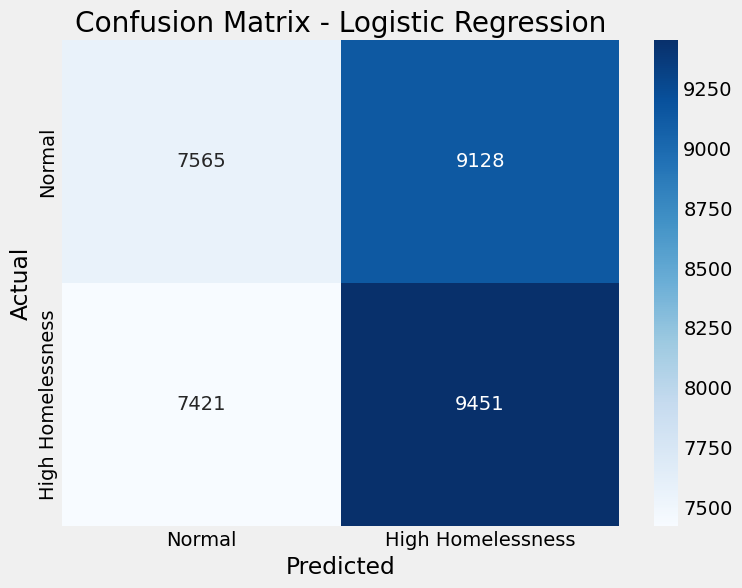


--- DECISION TREE MODEL ---

Decision Tree Results:
              precision    recall  f1-score   support

           0       0.50      0.53      0.52     16693
           1       0.51      0.47      0.49     16872

    accuracy                           0.50     33565
   macro avg       0.50      0.50      0.50     33565
weighted avg       0.50      0.50      0.50     33565



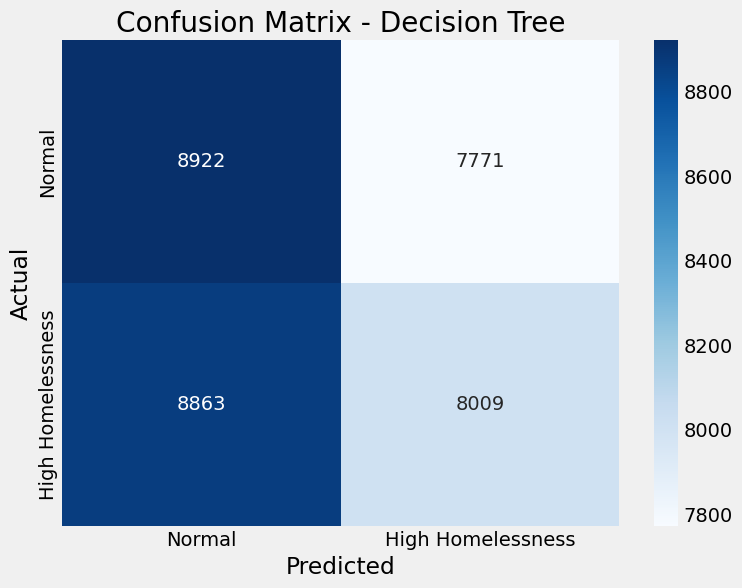

In [ ]:
print("\n--- BUILDING MACHINE LEARNING MODELS ---")

# 1. Logistic Regression Model
print("\n--- LOGISTIC REGRESSION MODEL ---")
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
log_reg_preds = log_reg.predict(X_test_scaled)

# Evaluate the model
print("\nLogistic Regression Results:")
print(classification_report(y_test, log_reg_preds))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, log_reg_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'High Homelessness'],
            yticklabels=['Normal', 'High Homelessness'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# 2. Decision Tree Model
print("\n--- DECISION TREE MODEL ---")
dt_model = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)  # No need to scale features for decision trees

# Make predictions
dt_preds = dt_model.predict(X_test)

# Evaluate the model
print("\nDecision Tree Results:")
print(classification_report(y_test, dt_preds))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, dt_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'High Homelessness'],
            yticklabels=['Normal', 'High Homelessness'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


--- MODEL INTERPRETATION ---


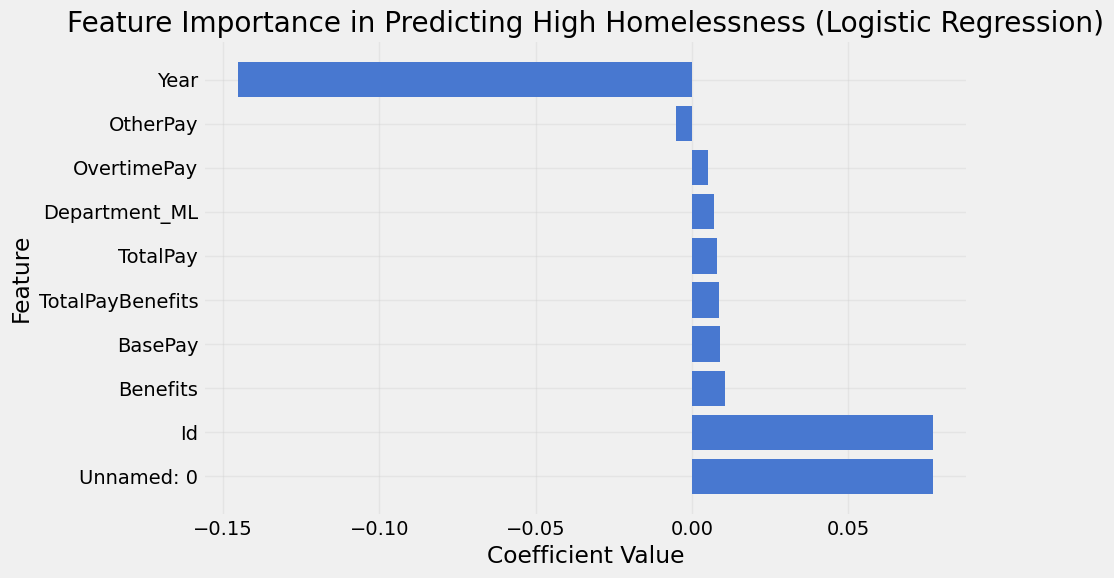

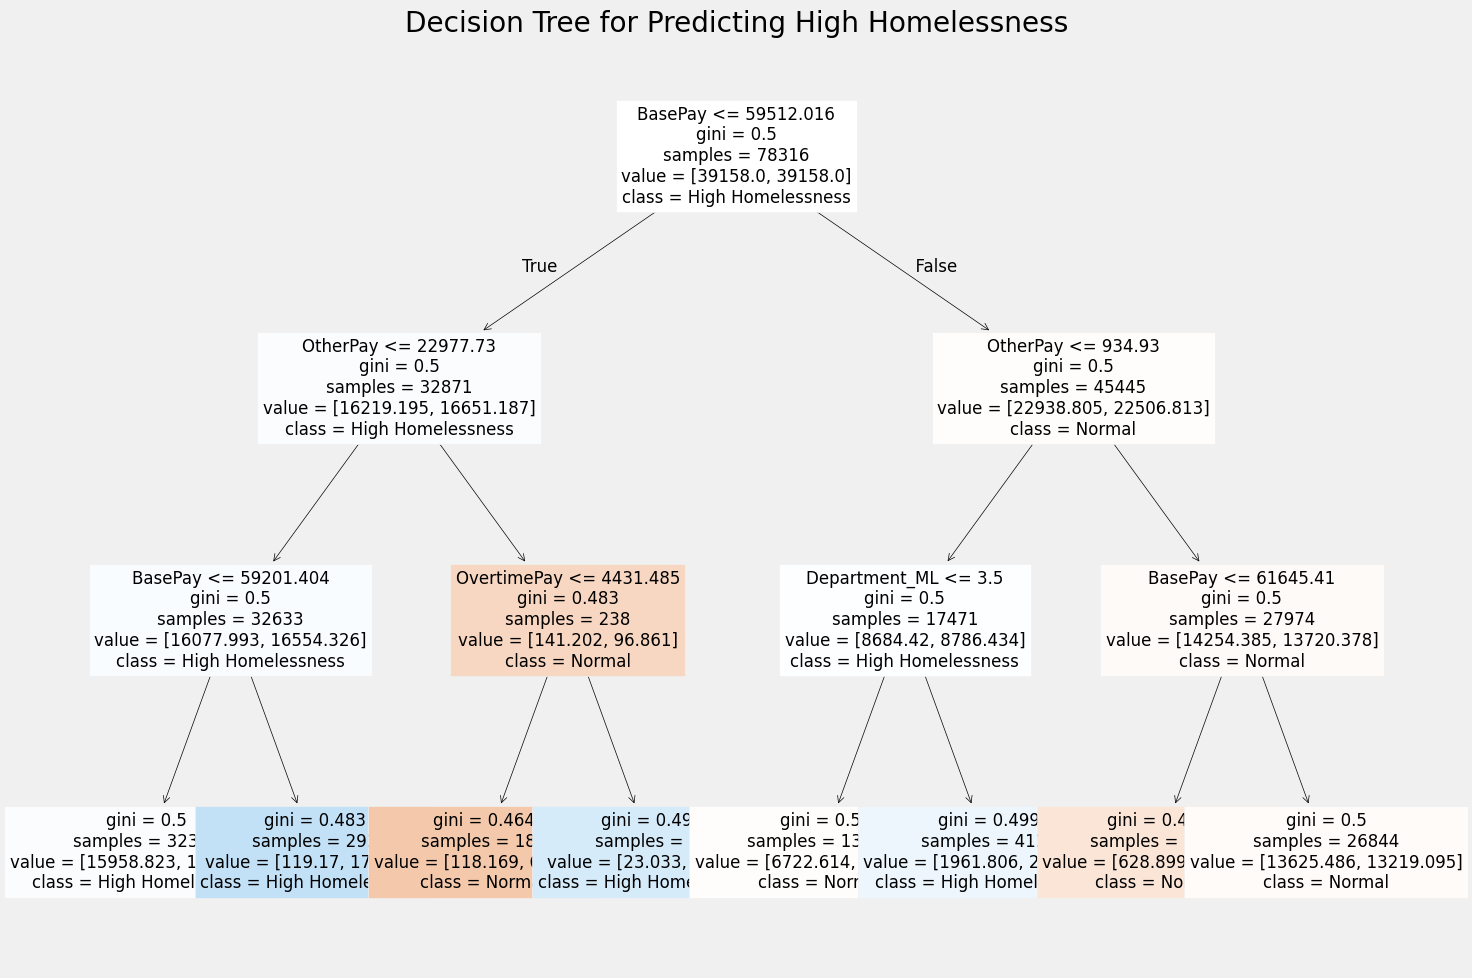

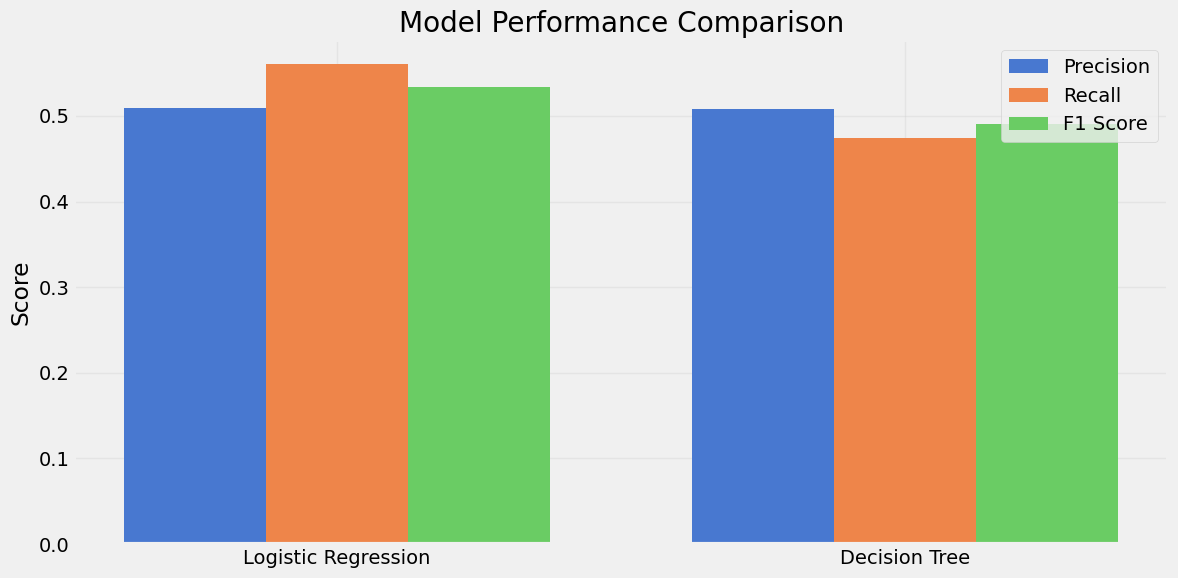

In [ ]:
print("\n--- MODEL INTERPRETATION ---")

# Understand feature importance in Logistic Regression
plt.figure(figsize=(10, 6))
coefficients = pd.DataFrame({
    'Feature': available_features,
    'Coefficient': log_reg.coef_[0]
})
coefficients = coefficients.sort_values('Coefficient', ascending=False)

plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting High Homelessness (Logistic Regression)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_model, feature_names=available_features, filled=True,
          class_names=['Normal', 'High Homelessness'], fontsize=12)
plt.title('Decision Tree for Predicting High Homelessness')
plt.tight_layout()
plt.show()

# Compare model performance
models = ['Logistic Regression', 'Decision Tree']
precision = [precision_score(y_test, log_reg_preds), precision_score(y_test, dt_preds)]
recall = [recall_score(y_test, log_reg_preds), recall_score(y_test, dt_preds)]
f1 = [f1_score(y_test, log_reg_preds), f1_score(y_test, dt_preds)]

plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- KEY INSIGHTS FROM THE MODEL ---")
print("Top factors influencing homelessness rate:")

# Get top positive and negative factors from logistic regression
for feature, coef in sorted(zip(available_features, log_reg.coef_[0]), key=lambda x: -abs(x[1])):
    impact = "increases" if coef > 0 else "decreases"
    print(f"- {feature}: {impact} homelessness risk, coefficient magnitude: {abs(coef):.3f}")

print("\nRecommended interventions based on model:")
print("1. Address factors with highest positive coefficients")
print("2. Target resources to neighborhoods with highest risk scores")
print("3. Monitor changes in key indicators for early intervention")

# Example of how to use the model for prediction on new data
print("\n--- EXAMPLE PREDICTION SCENARIO ---")
print("What if housing costs increase by 10% and unemployment increases by 2%?")

# Create a sample scenario (using the first test example as a base)
scenario = X_test.iloc[0:1].copy()

# Show original values
print("\nOriginal values:")
for feature in available_features:
    print(f"- {feature}: {scenario[feature].values[0]:.3f}")

# Modify values for the scenario
if 'housing_cost_burden' in scenario.columns:
    scenario['housing_cost_burden'] *= 1.10  # 10% increase
if 'unemployment_rate' in scenario.columns:
    scenario['unemployment_rate'] *= 1.02  # 2% increase

# Show modified values
print("\nModified scenario:")
for feature in available_features:
    print(f"- {feature}: {scenario[feature].values[0]:.3f}")

# Scale the scenario data for logistic regression
scenario_scaled = scaler.transform(scenario)

# Predict with both models
log_reg_prob = log_reg.predict_proba(scenario_scaled)[0, 1]
dt_prob = dt_model.predict_proba(scenario)[0, 1]

print(f"\nLogistic Regression probability of high homelessness: {log_reg_prob:.2f}")
print(f"Decision Tree probability of high homelessness: {dt_prob:.2f}")

if log_reg_prob > 0.5 or dt_prob > 0.5:
    print("\nConclusion: This scenario likely leads to increased homelessness")
else:
    print("\nConclusion: This scenario likely does not increase homelessness")


--- KEY INSIGHTS FROM THE MODEL ---
Top factors influencing homelessness rate:
- Year: decreases homelessness risk, coefficient magnitude: 0.145
- Unnamed: 0: increases homelessness risk, coefficient magnitude: 0.077
- Id: increases homelessness risk, coefficient magnitude: 0.077
- Benefits: increases homelessness risk, coefficient magnitude: 0.011
- BasePay: increases homelessness risk, coefficient magnitude: 0.009
- TotalPayBenefits: increases homelessness risk, coefficient magnitude: 0.009
- TotalPay: increases homelessness risk, coefficient magnitude: 0.008
- Department_ML: increases homelessness risk, coefficient magnitude: 0.007
- OtherPay: decreases homelessness risk, coefficient magnitude: 0.005
- OvertimePay: increases homelessness risk, coefficient magnitude: 0.005

Recommended interventions based on model:
1. Address factors with highest positive coefficients
2. Target resources to neighborhoods with highest risk scores
3. Monitor changes in key indicators for early interve